In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

STARTING = -3
FINISHING = 1
OUTOFTRACK = 0
TRACK = -1
MAX_SPEED = 4
EPSILON = 0.7
GAMMA = 1

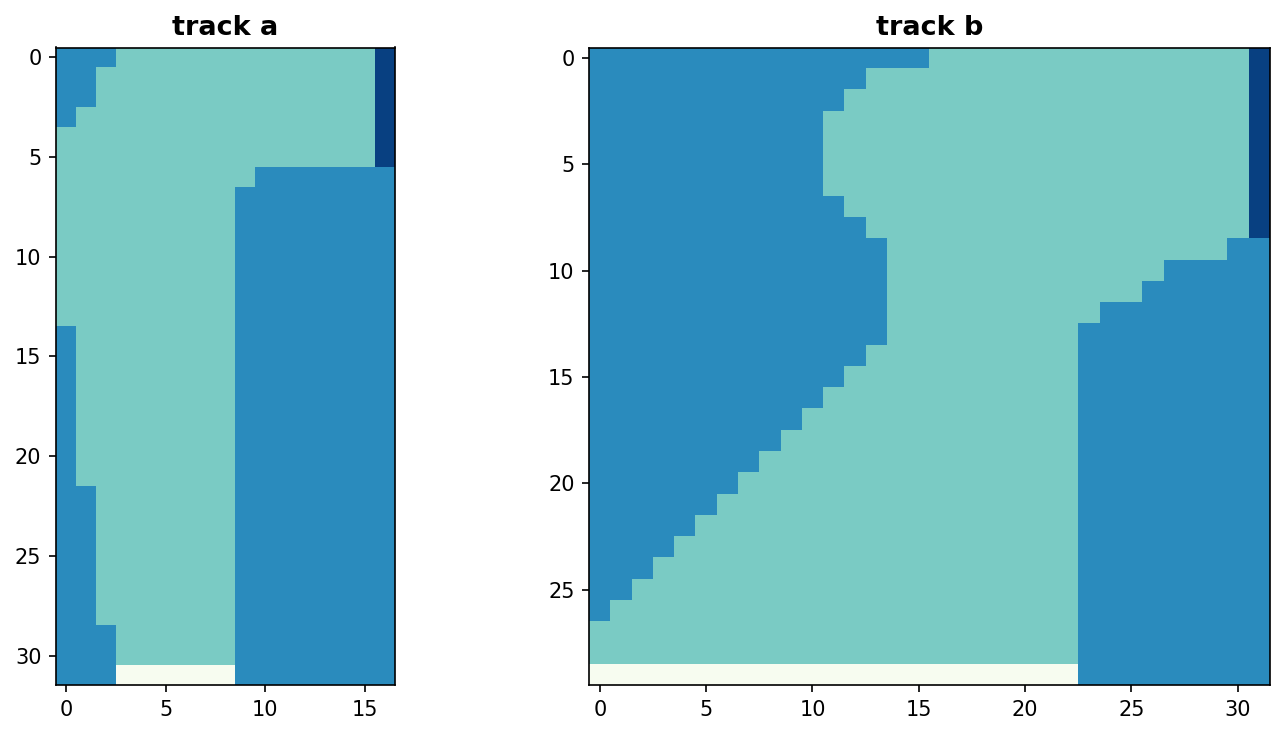

In [2]:
def build_track_a(save_map=False):
    track = - np.ones(shape=(32, 17))
    track[14:, 0] = OUTOFTRACK
    track[22:, 1] = OUTOFTRACK
    track[-3:, 2] = OUTOFTRACK
    track[:4, 0] = OUTOFTRACK
    track[:3, 1] = OUTOFTRACK
    track[0, 2] = OUTOFTRACK
    track[6:, -8:] = OUTOFTRACK

    track[6, 9] = TRACK

    track[:6, -1] = FINISHING
    track[-1, 3:9] = STARTING 
    
    if save_map:
        with open('./tracks/track_a.npy', 'wb') as f:
            np.save(f, track)
    return track

def build_track_b(save_map=False):
    track = -np.ones(shape=(30, 32))

    for i in range(14):
        track[:(-3 - i), i] = OUTOFTRACK
    
    track[3:7, 11] = TRACK
    track[2:8, 12] = TRACK
    track[1:9, 13] = TRACK
   
    track[0, 14:16] = OUTOFTRACK
    track[-17:, -9:] = OUTOFTRACK
    track[12, -8:] = OUTOFTRACK
    track[11, -6:] = OUTOFTRACK
    track[10, -5:] = OUTOFTRACK
    track[9, -2:] = OUTOFTRACK

    track[-1] = np.where(track[-1] == OUTOFTRACK, OUTOFTRACK, STARTING)
    track[:, -1] = np.where(track[:, -1] == OUTOFTRACK, OUTOFTRACK, FINISHING)
    if save_map:
        with open('./tracks/track_b.npy', 'wb') as f:
            np.save(f, track)
    return track

track_a = build_track_a(save_map=True)
track_b = build_track_b(save_map=True)
plt.figure(figsize=(10, 5), dpi=150)
for i, map_type in enumerate(['a','b']):
    with open(f'./tracks/track_{map_type}.npy', 'rb') as f:
        A = np.load(f)
    ax = plt.subplot(1, 2, i+1)
    ax.imshow(A, cmap='GnBu')
    ax.set_title(f'track {map_type}', fontdict={'fontsize': 13, 'fontweight':'bold'})
track_a = build_track_a(save_map=True)
track_b = build_track_b(save_map=True)
plt.tight_layout()
plt.savefig('maps.png')
plt.show()

In [3]:
class Racetrack_env():
    def __init__(self,track):
        self.racetrack = track
        self.starting_line = self.get_starting_line()
        self.car_pos = self.get_starting_pos()
        self.car_speed = [0,0]

    def get_speed(self):
        return self.car_speed
    
    def get_pos(self):
        return self.car_pos
    
    def get_starting_pos(self):
        return random.choice(self.starting_line)
    
    def get_starting_line(self):
        starting_line = []
        for col in range(self.racetrack.shape[0]):
            for row in range(self.racetrack.shape[1]):
                if self.racetrack[col][row] == STARTING:
                    starting_line.append([col,row])
        return starting_line

    #manda o carro pro começo da pista
    def start_again(self):
        self.car_speed = [0,0]
        self.car_pos = self.get_starting_pos()
        return (self.car_pos,self.car_speed)
    
    #retorna True se ganhou e False se não ganhou
    def check_win(self,initial_pos,final_pos):
        for col in range(final_pos[0],initial_pos[0]+1):
            for row in range(initial_pos[1],final_pos[1]+1):
                if self.racetrack.shape[0] > col and self.racetrack.shape[1] > row:
                    if col>=0 and row >= 0:
                        if self.racetrack[col][row] == FINISHING:
                            return True
        return False
    
    #retorna True se saiu e False se não saiu
    def check_out(self,initial_pos,final_pos):
        
        for col in range(final_pos[0],initial_pos[0]+1):
            for row in range(initial_pos[1],final_pos[1]+1):
                if self.racetrack.shape[0] < col or self.racetrack.shape[1] < row :
                    return True
                if col < 0 or row < 0:
                    return True
                if self.racetrack[col][row] == OUTOFTRACK:
                    return True
        return False
    
    #action é uma lista de algum dos seguintes formatos: (-1,0) (-1,1) (-1,-1) (0,0) (0,1) (0,-1) (1,0) (1,1) (1,-1)
    def take_step(self, action):

        if 0 < (self.car_speed[0] + action[0]) < MAX_SPEED: 
            self.car_speed[0] += action[0]

        if 0 < (self.car_speed[1] + action[1]) < MAX_SPEED: 
            self.car_speed[1] += action[1]

        new_pos = [self.car_pos[0] -self.car_speed[0] , self.car_pos[1] + self.car_speed[1] ]
        #checa se ganhou
        if self.check_win(self.car_pos,new_pos):
            return [100,[self.car_pos,self.car_speed]]
        
        else:
            #checa se saiu da pista
            if self.check_out(self.car_pos,new_pos):
                self.start_again()
                return [-20,[self.car_pos,self.car_speed]]
            
            else:
                self.car_pos = new_pos
                return [-1,[self.car_pos,self.car_speed]]
            
race = Racetrack_env(track_a)



In [4]:
class Agent:
    def __init__(self,race,track):
        self.track = track
        self.car_pos = race.get_pos()
        self.car_speed = race.get_speed()
        self.steps_trained = 0
        self.possible_actions = ((-1,-1),(-1,0),(0,-1),(-1,1),(0,0),(1,-1),(0,1),(1,0),(1,1))
        self.possible_speeds = np.array([(i, j) for i in range(4) for j in range(4)])
        self.Q , self.C = self.intialize_Q_C()
        self.pi = self.intialize_pi()

    def intialize_Q_C(self):
        Q = {}
        C = {}
        for col in range(race.racetrack.shape[0]):
            for row in range(race.racetrack.shape[1]):
                for x_speed in range(MAX_SPEED):
                    for y_speed in range(MAX_SPEED):
                        Q[(col,row,x_speed,y_speed)] = {}
                        C[(col,row,x_speed,y_speed)] = {}
                        for action in self.possible_actions:
                            Q[(col,row,x_speed,y_speed)][action] = 0
                            C[(col,row,x_speed,y_speed)][action] = 0
        return Q, C
    
    def intialize_pi(self):
        pi = {}
        for col in range(race.racetrack.shape[0]):
            for row in range(race.racetrack.shape[1]):
                for x_speed in range(MAX_SPEED):
                    for y_speed in range(MAX_SPEED):
                        pi[(col,row,x_speed,y_speed)] = (random.choice(self.possible_actions))
        return pi

    def behavior_pi(self,epsilon= 0.3):
        random_value = random.random()
        self.car_pos = race.get_pos()
        self.car_speed = race.get_speed()
        state = tuple([self.car_pos[0],self.car_pos[1],self.car_speed[0],self.car_speed[1]])
        #explora com probailidade epsilon
        if random_value < epsilon:
            action = random.choice(self.possible_actions)
            if action == self.pi[state]:
                prob = (1 - epsilon) + epsilon / len(self.possible_actions)
            else:
                prob = epsilon / len(self.possible_actions)
        #exploita com probailidade 1 - epsilon    
        else:
            action = self.pi[state]
            prob = (1 - epsilon) + epsilon / len(self.possible_actions)
        return action, prob

    def generate_episode(self):
        states, speeds ,actions, rewards, probs = [], [] ,[], [], []
        race.start_again()  # Reset the environment
        self.car_pos = race.get_pos()
        self.car_speed = race.get_speed()
        while True:
            #escolhe a ação 
            action,prob = self.behavior_pi()  
            states.append(tuple(self.car_pos))
            speeds.append(tuple(self.car_speed))
            actions.append(action)
            probs.append(prob)
            reward, pos_speed = race.take_step(action)
            self.car_pos, self.car_speed = pos_speed
            rewards.append(reward)
            if reward == 100:
                return list(zip(states,speeds,actions, rewards, probs))

    def generate_pi_episode(self):
        states, speeds ,actions, rewards, probs = [], [] ,[], [], []
        race.start_again()  # Reset the environment
        self.car_pos = race.get_pos()
        self.car_speed = race.get_speed()
        count = 0
        
        while True:
            state = tuple([self.car_pos[0],self.car_pos[1],self.car_speed[0],self.car_speed[1]])
            #escolhe a ação 
            action = self.pi[state]
            states.append(tuple(self.car_pos))
            speeds.append(tuple(self.car_speed))
            actions.append(action)
            reward, pos_speed = race.take_step(action)
            self.car_pos, self.car_speed = pos_speed
            rewards.append(reward)
            count += 1
            if reward == 100:
                print('number of actions taken:')
                print(count)
                self.generate_render_episode(states)
                return list(zip(states,speeds ,actions, rewards, probs))
        
    def generate_render_episode(self, states):
        track = np.copy(self.track)
        for state in states:
            print(state)
            track[state[0]][state[1]] = -2
            
        ax = plt.subplot(1, 2, i+1)
        ax.imshow(track, cmap='GnBu')
        ax.set_title(f'track', fontdict={'fontsize': 13, 'fontweight':'bold'})
        plt.tight_layout()
        plt.show()
        
    def update_pi(self):
        for state in self.Q:
            # Get the maximum Q-value for this state
            max_q_value = max(self.Q[state].values())
            # Find all actions that have this maximum Q-value
            max_actions = [action for action, q_value in self.Q[state].items() if q_value == max_q_value]
            # Randomly select one of these actions
            self.pi[state] = random.choice(max_actions)
    
    def train(self, episodes):
        for episode in range(episodes):
            if episode%10 == 0:
                print(episode)
            episode_data = self.generate_episode()
            G = 0
            W = 1
            for data in reversed(episode_data):
                pos,speed, action, reward, prob = data
                state = tuple([pos[0],pos[1],speed[0],speed[1]])
                G = GAMMA * G + reward
                self.C[state][action] += W
                self.Q[state][action] += (W / self.C[state][action]) * (G - self.Q[state][action])
                self.update_pi()  
                if action != self.pi[tuple(state)]:
                    break
                W = W/prob





In [5]:
race = Racetrack_env(track_a)
agentA= Agent(race,track_a)

In [7]:
#1000 = 1 minuto
agentA.train(2000)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


Como ele resolveu um episódio em relativamente poucos passos, logo conseguiu treinar direito e o modelo ta funcionando.

number of actions taken:
13
(31, 4)
(30, 4)
(28, 4)
(25, 4)
(22, 4)
(20, 4)
(17, 4)
(14, 4)
(11, 5)
(8, 7)
(5, 8)
(2, 10)
(0, 13)


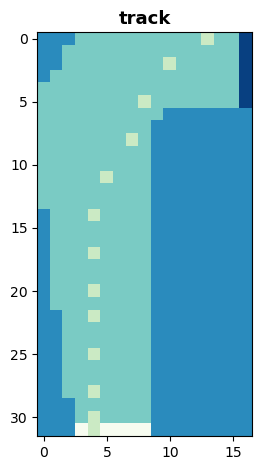

number of actions taken:
13
(31, 4)
(30, 4)
(28, 4)
(25, 4)
(22, 4)
(20, 4)
(17, 4)
(14, 4)
(11, 5)
(8, 7)
(5, 8)
(2, 10)
(0, 13)


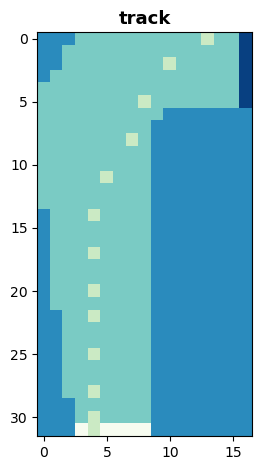

number of actions taken:
16
(31, 6)
(31, 7)
(31, 8)
(31, 4)
(30, 4)
(28, 4)
(25, 4)
(22, 4)
(20, 4)
(17, 4)
(14, 4)
(11, 5)
(8, 7)
(5, 8)
(2, 10)
(0, 13)


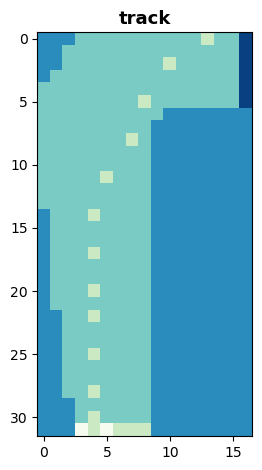

In [8]:
for k in range(3):
    agentA.generate_pi_episode()

In [11]:
raceB = Racetrack_env(track_b)
agentB = Agent(raceB,track_b)
agentB.train(2000)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


In [12]:
for k in range(3):
    agentB.generate_pi_episode()

number of actions taken:
17
(31, 5)


IndexError: index 31 is out of bounds for axis 0 with size 30